In [1]:
%load_ext autoreload
%autoreload 2

# Using ANN to model Indoor Temperature Values for a building

Aim: Estimate an average temperature for the building given prev temperature and current heating/ cooling system operation values and external Environment  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# add the path to the root folder
path_to_main = "../../"

In [4]:
import sys

sys.path.append(path_to_main)

In [5]:
import pandas as pd
from src.data.load_traning_data import load, combine
from matplotlib import pyplot as plt

In [6]:
data = load(path_to_data_folder=path_to_main)
combined_df = (
    combine(data)
    .drop(["DD", "FH", "R", "S", "U"], axis=1)
    .assign(ZAT_t_1=lambda x: x.ZAT.shift(periods=1, fill_value=20))
)

In [7]:
combined_df.isna().any()

AHU 1#setpoint                                  False
AHU 1#fan                                       False
AHU 1#sensor                                    False
Primary HW1#sensor                              False
Primary HW1#setpoint                            False
Secondary HW.Radiators.HeatingCurve#sensor      False
Secondary HW.Radiators.HeatingCurve#setpoint    False
temperature                                     False
ghi                                             False
ZAT                                             False
ZAT_t_1                                         False
dtype: bool

In [8]:
# removing outliers and also year 2021 as it has weird data
precessed_data: pd.DataFrame = combined_df.loc[
    (combined_df.index.year >= 2022) & (combined_df["ZAT"] < 40)
]

In [9]:
X_train_normal = precessed_data.loc[:"2023-12-31"].drop(["ZAT"], axis=1)
X_test_normal = precessed_data.loc["2024-01-01":].drop(["ZAT"], axis=1)
y_train_normal = precessed_data.loc[:"2023-12-31", ["ZAT"]]
y_test_normal = precessed_data.loc["2024-01-01":, ["ZAT"]]

In [10]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
x_scaler.fit(X_train_normal)
y_scaler = MinMaxScaler()
y_scaler.fit(y_train_normal)

X_train = x_scaler.transform(X_train_normal)
X_test = x_scaler.transform(X_test_normal)
y_train = y_scaler.transform(y_train_normal)
y_test = y_scaler.transform(y_test_normal)

In [11]:
# # X_train = scaled_train[:, list(range(9)) + [10]]
# X_train = scaled_train[:, list(range(9))]
# y_train = scaled_train[:, 9].reshape(-1, 1)

# # X_test = scaled_test[:, list(range(9)) + [10]]
# X_test = scaled_test[:, list(range(9))]
# y_test = scaled_test[:, 9].reshape(-1, 1)

In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [13]:
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
# Define the ANN model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(input_dim, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_layer_size // 2, 1),
        )

    def forward(self, x):
        return self.network(x)

In [15]:
# Hyper-parameters

input_size = X_train.shape[1]  # no. of input nodes
hidden_layer_size = 256
learning_rate = 0.001
batch_size = 24 * 7
num_epochs = 5

In [16]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([168, 10])
torch.Size([168, 1])


In [18]:
from tqdm import tqdm
import mlflow
import mlflow.pytorch

In [19]:
def train_one_epoch(epoch, model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    avg_loss = []
    n_total_steps = len(train_loader)

    print(f"Epoch: {epoch + 1}")

    for i, (x, y) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
    ):
        # Forward pass
        output = model(x)
        loss = criterion(output, y)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 5 == 0:
            avg_loss_across_batches = running_loss / 5
            avg_loss.append(avg_loss_across_batches)
            running_loss = 0.0
    mlflow.log_metric(
        "avg_loss",
        sum(avg_loss) / len(avg_loss),
        step=epoch,
    )
    return avg_loss

In [20]:
def validate_one_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Validation", leave=False):
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

In [21]:
def plot_losses(epoch_results):
    train_losses = [
        sum(epoch.train_losses) / len(epoch.train_losses) for epoch in epoch_results
    ]
    val_losses = [
        sum(epoch.val_losses) / len(epoch.val_losses) for epoch in epoch_results
    ]
    epochs = range(1, len(epoch_results) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [22]:
from dataclasses import dataclass, field
from typing import List


@dataclass
class EpochResult:
    train_losses: List[float] = field(default_factory=list)
    val_losses: List[float] = field(default_factory=list)

NameError: name 'model' is not defined

In [24]:
def train_and_evaluate(train_loader, hidden_layer_size, learning_rate, num_epochs):
    model = ANNModel(input_dim=input_size, hidden_layer_size=hidden_layer_size)
    criterion = torch.nn.MSELoss()  # loss function good for Numerical
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_results = []
    for epoch in range(num_epochs):
        train_losses = train_one_epoch(epoch, model, train_loader, criterion, optimizer)
        val_loss = validate_one_epoch(model, test_loader, criterion)

        epoch_result = EpochResult(train_losses=train_losses, val_losses=[val_loss])
        epoch_results.append(epoch_result)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {sum(train_losses)/len(train_losses):.4f}, Validation Loss: {val_loss:.4f}"
        )

In [27]:
mlflow.set_tracking_uri("http://localhost:5000")
# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

2024/07/24 22:47:59 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Quickstart' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/832161825025692559', creation_time=1721854079564, experiment_id='832161825025692559', last_update_time=1721854079564, lifecycle_stage='active', name='MLflow Quickstart', tags={}>

In [ ]:
from torchinfo import summary

num_epochs = 80
hidden_layer_size = 256
learning_rate = 0.001
model = ANNModel(input_dim=input_size, hidden_layer_size=hidden_layer_size)
criterion = torch.nn.MSELoss()  # loss function good for Numerical
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
with mlflow.start_run() as run:
    params = {
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": criterion.__class__.__name__,
        # "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    epoch_results = []
    for epoch in range(num_epochs):
        train_losses = train_one_epoch(epoch, model, train_loader, criterion, optimizer)
        val_loss = validate_one_epoch(model, test_loader, criterion)

        epoch_result = EpochResult(train_losses=train_losses, val_losses=[val_loss])
        epoch_results.append(epoch_result)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {sum(train_losses)/len(train_losses):.4f}, Validation Loss: {val_loss:.4f}"
        )

    plot_losses(epoch_results)

In [95]:
# Experiment settings
hidden_layer_sizes = [128, 256, 512]
learning_rates = [0.01, 0.001, 0.0001]
num_epochs_list = [1]  # [5, 10, 20]
# Running experiments
for hidden_layer_size in hidden_layer_sizes:
    for learning_rate in learning_rates:
        for num_epochs in num_epochs_list:
            with mlflow.start_run():
                mlflow.log_param("hidden_layer_size", hidden_layer_size)
                mlflow.log_param("learning_rate", learning_rate)
                mlflow.log_param("num_epochs", num_epochs)
                train_and_evaluate(
                    train_loader, hidden_layer_size, learning_rate, num_epochs
                )

Epoch: 1


Epoch [1/1], Training Loss: 0.0225, Validation Loss: 0.0124
Epoch: 1


Epoch [1/1], Training Loss: 0.0218, Validation Loss: 0.0102
Epoch: 1


Epoch [1/1], Training Loss: 0.1478, Validation Loss: 0.0293
Epoch: 1


Epoch [1/1], Training Loss: 0.0174, Validation Loss: 0.0074
Epoch: 1


Epoch [1/1], Training Loss: 0.0159, Validation Loss: 0.0137
Epoch: 1


Epoch [1/1], Training Loss: 0.1335, Validation Loss: 0.0051
Epoch: 1


Epoch [1/1], Training Loss: 0.0407, Validation Loss: 0.0066
Epoch: 1


Epoch [1/1], Training Loss: 0.0175, Validation Loss: 0.0115
Epoch: 1


Epoch [1/1], Training Loss: 0.0374, Validation Loss: 0.0088


In [38]:
with torch.no_grad():
    predictions = model.forward(X_train)

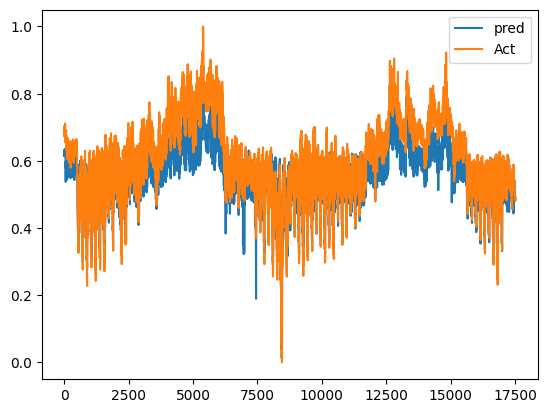

In [39]:
plt.plot(predictions.numpy().squeeze(), label="pred")
plt.plot(y_train, label="Act")
plt.legend()

In [76]:
import numpy as np

zat = 0.6
predictions = []
for x_test in X_test[:, range(0, 9)]:
    zat = torch.tensor([zat])
    x_test = torch.cat((x_test, zat))
    with torch.no_grad():
        zat = model.forward(x_test)
    predictions.append(zat.item())

predictions = np.array(predictions)

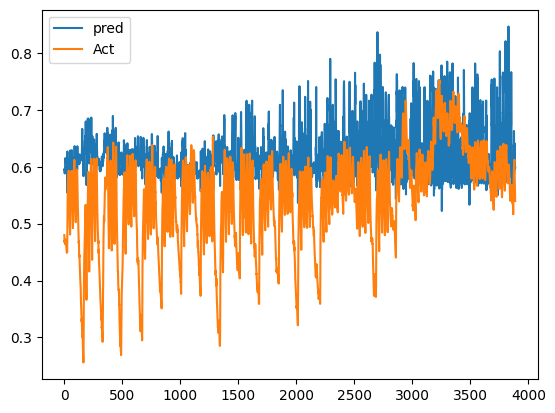

In [77]:
plt.plot(predictions, label="pred")
plt.plot(y_test, label="Act")
plt.legend()

In [78]:
normal_test_predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1))

In [79]:
X_test_normal["Actual"] = y_test_normal["ZAT"]
X_test_normal["normal_test_predictions"] = normal_test_predictions.reshape(
    len(normal_test_predictions)
)

<Axes: xlabel='datetime'>

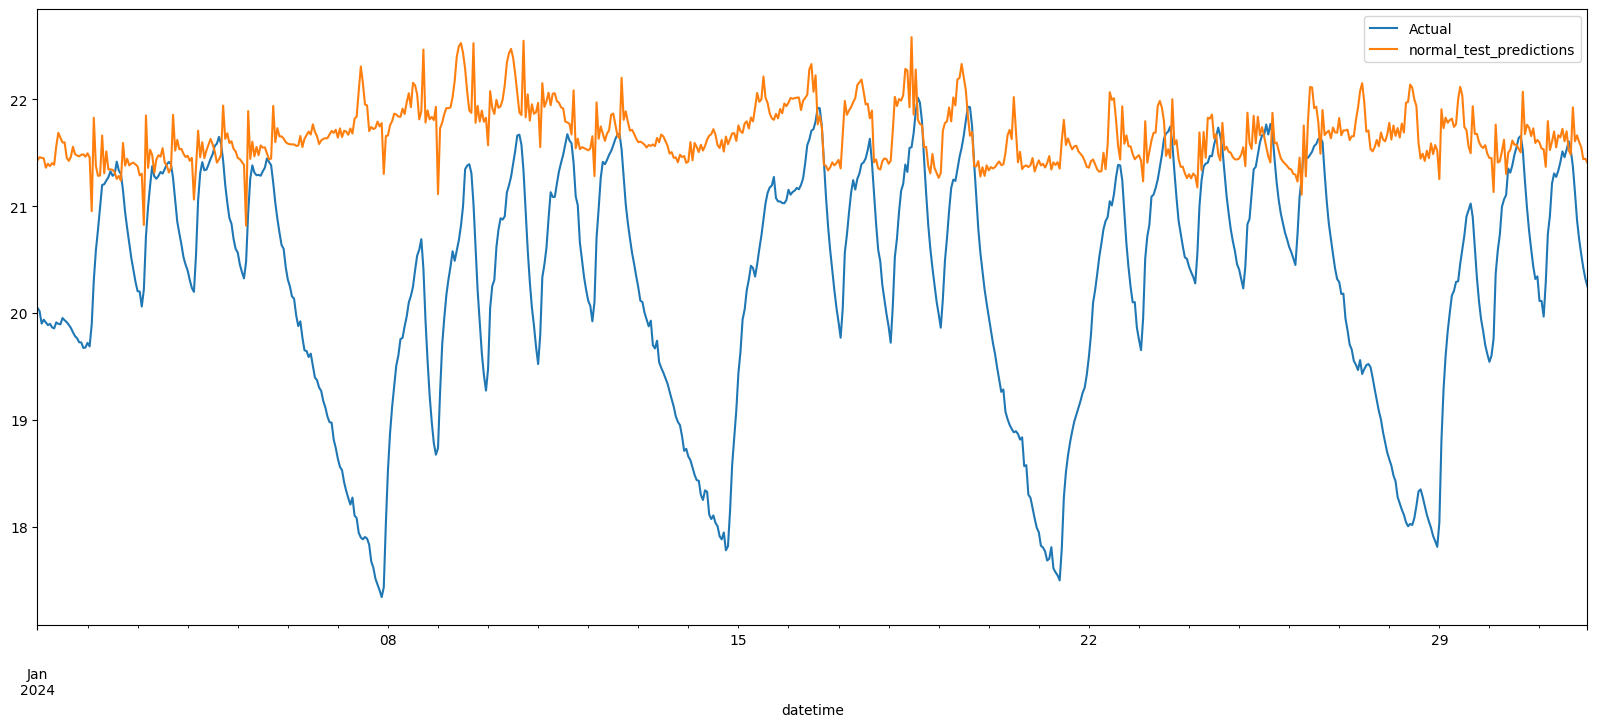

In [80]:
X_test_normal.loc["2024-01", ["Actual", "normal_test_predictions"]].plot(
    figsize=(20, 8)
)

<Axes: xlabel='datetime'>

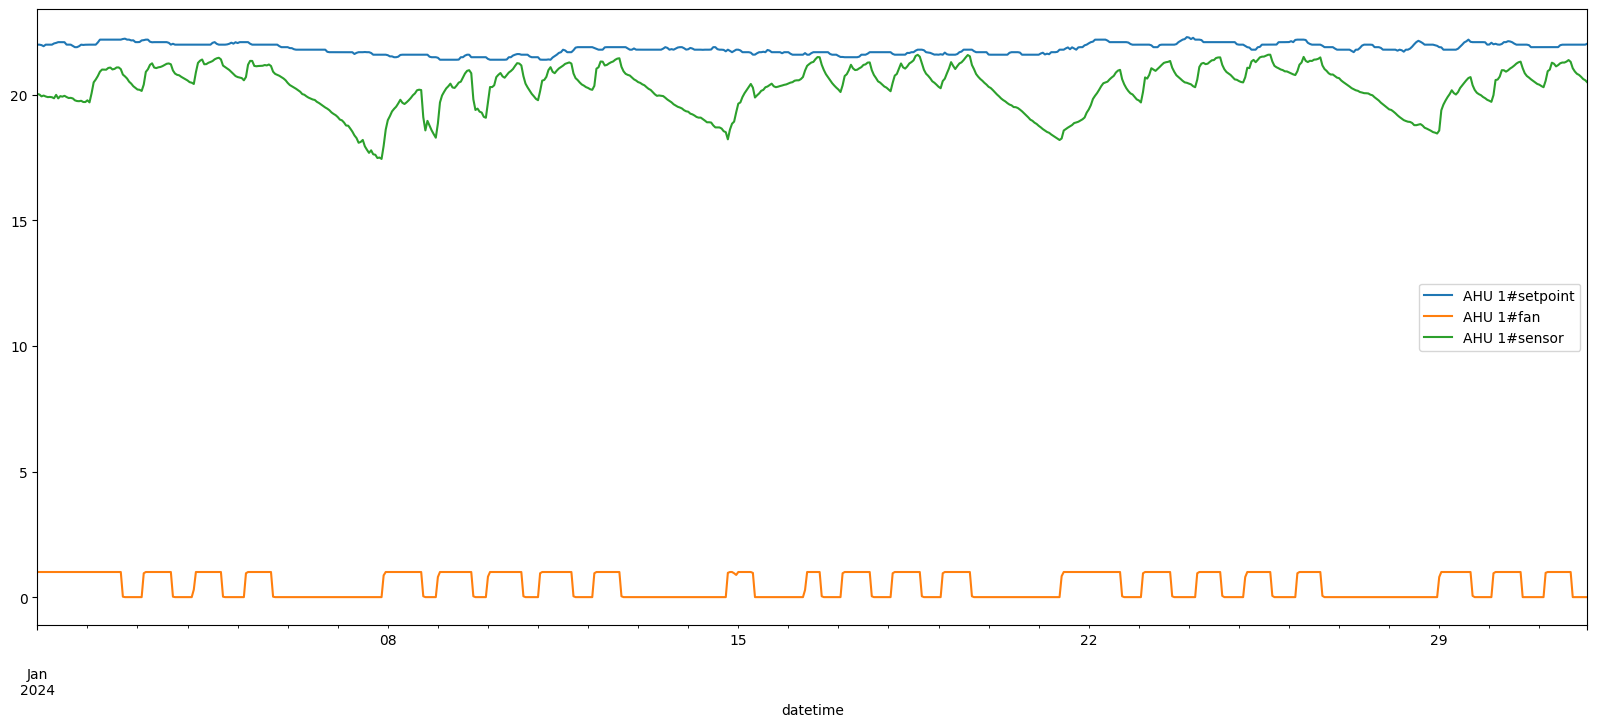

In [44]:
X_test_normal.loc[
    "2024-01",
    [
        "AHU 1#setpoint",
        "AHU 1#fan",
        "AHU 1#sensor",
    ],
].plot(figsize=(20, 8))

<Axes: xlabel='datetime'>

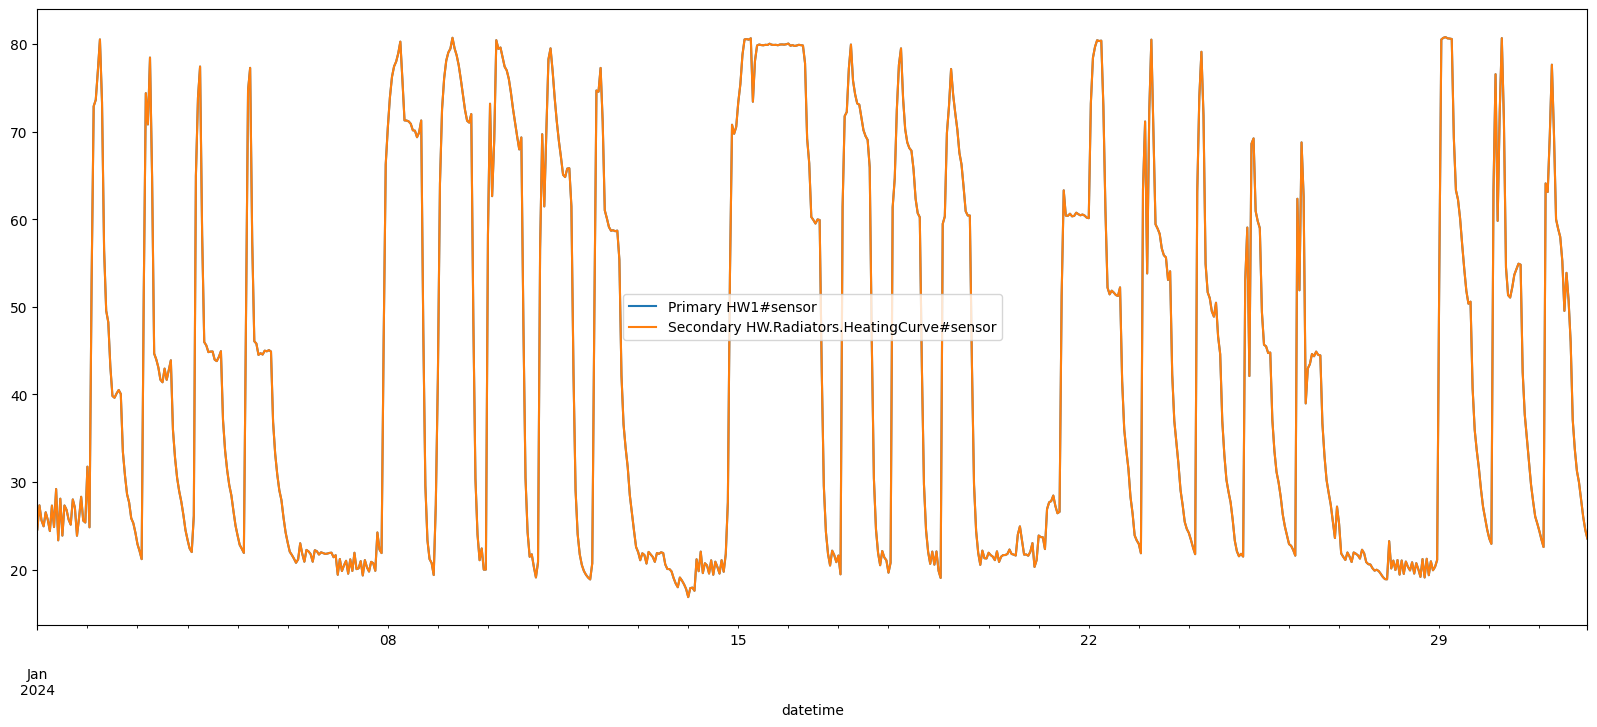

In [43]:
X_test_normal.loc[
    "2024-01",
    [
        "Primary HW1#sensor",
        #  "Primary HW1#setpoint",
        "Secondary HW.Radiators.HeatingCurve#sensor",
        #  "Secondary HW.Radiators.HeatingCurve#setpoint",
    ],
].plot(figsize=(20, 8))

In [39]:
X_test_normal.columns

Index(['AHU 1#setpoint', 'AHU 1#fan', 'AHU 1#sensor', 'Primary HW1#sensor',
       'Primary HW1#setpoint', 'Secondary HW.Radiators.HeatingCurve#sensor',
       'Secondary HW.Radiators.HeatingCurve#setpoint', 'temperature', 'ghi',
       'Actual', 'normal_test_predictions'],
      dtype='object')

In [45]:
X_train_normal

,AHU 1#setpoint,AHU 1#fan,AHU 1#sensor,Primary HW1#sensor,Primary HW1#setpoint,Secondary HW.Radiators.HeatingCurve#sensor,Secondary HW.Radiators.HeatingCurve#setpoint,temperature,ghi
datetime,,,,,,,,,
2022-01-01 00:00:00+00:00,22.200001,0.0,22.323332,59.041668,57.450001,59.041668,20.000000,9.2,0.0
2022-01-01 01:00:00+00:00,22.200001,0.0,22.320000,59.511665,57.333332,59.511665,20.000000,9.5,0.0
2022-01-01 02:00:00+00:00,22.200001,0.0,22.333332,57.993332,56.503334,57.993332,20.000000,8.4,0.0
2022-01-01 03:00:00+00:00,22.200001,0.0,22.336666,57.811668,56.189999,57.811668,20.000000,10.5,0.0
2022-01-01 04:00:00+00:00,22.241667,0.0,22.334999,56.195000,54.553333,56.195000,20.000000,11.6,0.0
...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,22.000000,1.0,20.133333,22.993334,20.213333,22.993334,20.208334,8.0,0.0
2023-12-31 20:00:00+00:00,22.000000,1.0,20.106667,26.451666,25.943333,26.451666,22.233334,8.1,0.0
2023-12-31 21:00:00+00:00,22.000000,1.0,20.076666,22.971666,21.238333,22.971666,20.093334,7.9,0.0
